## Vinh Nguyen - 300473488
<br>

<h1 align='center'>Dataset Key Information</h1>
<h2>Training Data</h2>
<b>patient_notes.csv - A collection of about 40,000 Patient Note history portions.</b><br>

* ```pn_num``` - A unique identifier for each patient note.
* ```case_num``` - A unique identifier for the clinical case a patient note represents.
* ```pn_history``` - The text of the encounter as recorded by the test taker.

<b>features.csv - The rubric of features (or key concepts) for each clinical case.</b><br>
* ```feature_num``` - A unique identifier for each feature.
* ```case_num``` - A unique identifier for each case.
* ```feature_text``` - A description of the feature.

<b>train.csv - Feature annotations for 1000 of the patient notes, 100 for each of ten cases.</b><br>
* ```id``` - Unique identifier for each patient note / feature pair.
* ```pn_num``` - The patient note annotated in this row.
* ```feature_num``` - The feature annotated in this row.
* ```case_num``` - The case to which this patient note belongs.
* ```annotation``` - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
* ```location``` - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

# Library

In [1]:
import gc
import ast
import nltk
import spacy
import warnings
import stylecloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.figure_factory as ff

from spacy import displacy
from IPython.display import Image
from nltk.corpus import stopwords
from collections import Counter, defaultdict

sns.set_style("darkgrid")
warnings.simplefilter('ignore')

PATH = "/Users/ducvi/Documents/VIC/2023/T2/AIML430/Capstone/"

# Read-in the data

In [2]:
train =  pd.read_csv(PATH + 'data/train.csv')
train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14300 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14300 non-null  object
 1   case_num     14300 non-null  int64 
 2   pn_num       14300 non-null  int64 
 3   feature_num  14300 non-null  int64 
 4   annotation   14300 non-null  object
 5   location     14300 non-null  object
dtypes: int64(3), object(3)
memory usage: 670.4+ KB


In [4]:
feature = pd.read_csv(PATH + 'data/features.csv')
feature.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [5]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [6]:
patient_note = pd.read_csv(PATH + 'data/patient_notes.csv')
patient_note.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [7]:
patient_note.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pn_num      42146 non-null  int64 
 1   case_num    42146 non-null  int64 
 2   pn_history  42146 non-null  object
dtypes: int64(2), object(1)
memory usage: 987.9+ KB


<br> 
<br>

# Performing EDA

<a id='3.1'></a>

## Train Data

#### We will start by looking the distribution of case_num.

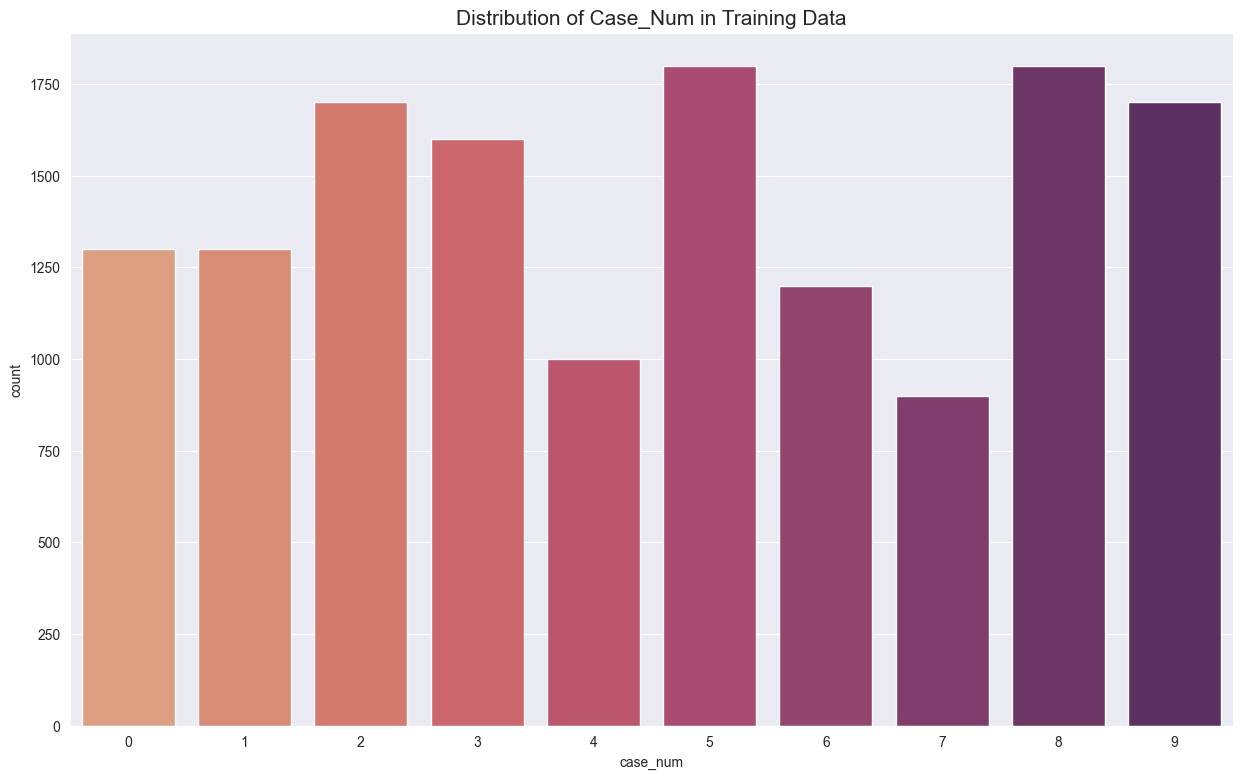

In [8]:
plt.figure(figsize=(15, 9))

sns.countplot(x='case_num', data=train, palette = 'flare')
plt.title('Distribution of Case_Num in Training Data', fontsize=15)

plt.show()

#### Then let's look the distribution of pn_num.

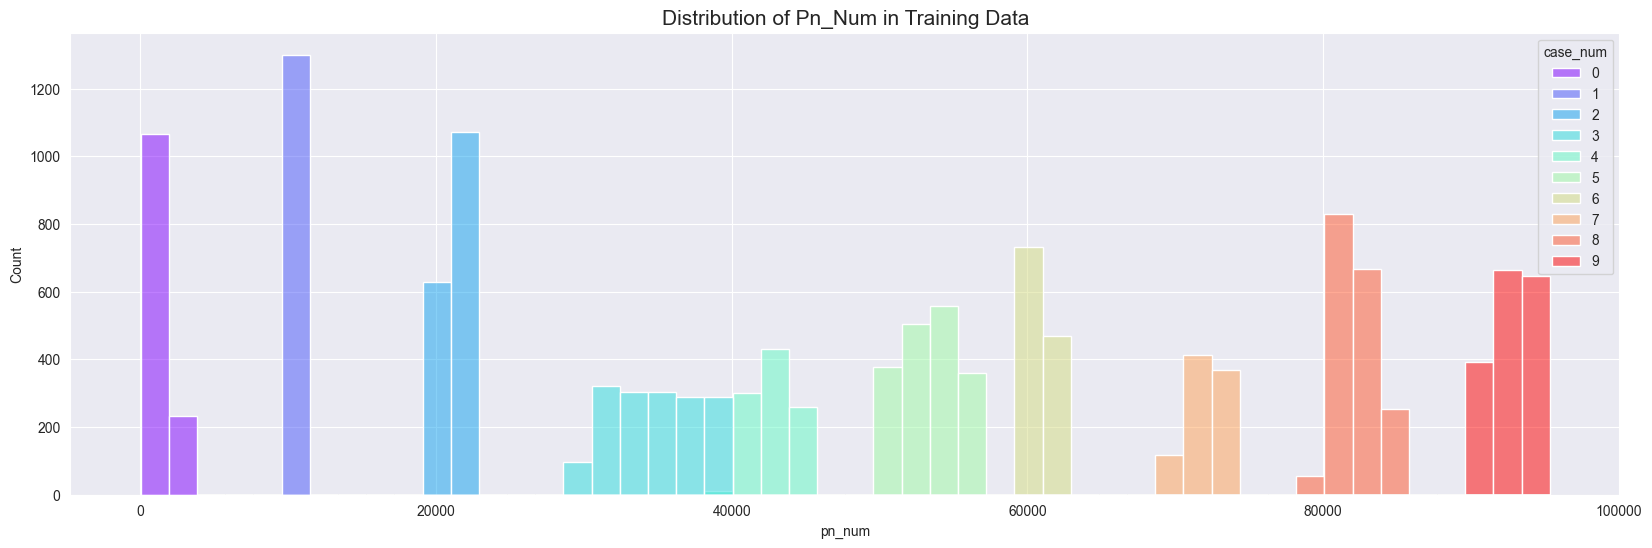

In [9]:
plt.figure(figsize=(20, 6))

sns.histplot(x='pn_num', data=train, hue='case_num', bins=50, palette='rainbow')
plt.title('Distribution of Pn_Num in Training Data', fontsize=15)

plt.show()

#### After that let's analyse the annotations. For this, first of all we will focus at the number of features in the annotations and then we will consider the most common words in the annotations.

Number of Rows with no Annotations - 4399
Number of Rows with Annotations - 9901


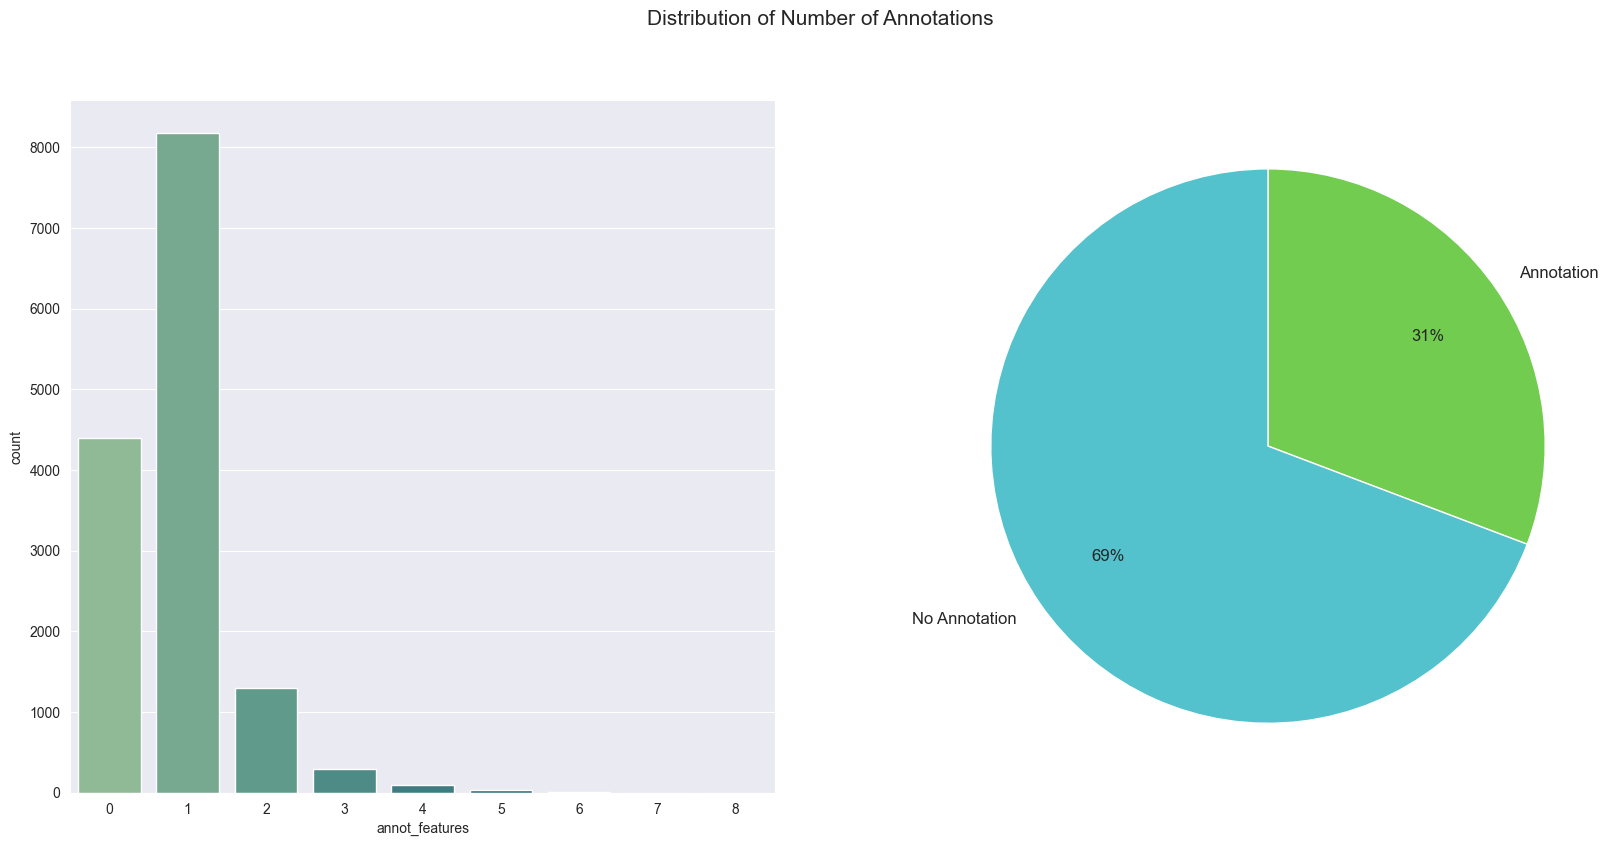

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Distribution of Number of Annotations', size=15)
train['annot_features'] = train['annotation'].apply(lambda x : len(ast.literal_eval(x))) 
sns.countplot(x=train['annot_features'], palette='crest', ax=ax[0])

sizes = []
no_annotations = len(train[train['annot_features']==0])
sizes.append(no_annotations)
annotated = len(train) - len(train[train['annot_features']==0])
sizes.append(annotated)

print('Number of Rows with no Annotations -', no_annotations)
print('Number of Rows with Annotations -', annotated)

labels = ['Annotation', 'No Annotation']
colors = ['#72CC50', '#54C2CC']
ax[1].pie(sizes, colors=colors, startangle=90, labels=labels,
        autopct='%1.0f%%', pctdistance=0.7,textprops={'fontsize':12}, counterclock=False)

plt.show()

In [11]:
nltk.download('stopwords')

def join_fea(annotation):
    text = [word for words in ast.literal_eval(annotation) for word in words.split() if word not in set(stopwords.words('english'))]
    return text

train['text'] = train['annotation'].apply(lambda x : join_fea(x))

top = Counter([word for words in train['text'] for word in words])
df_temp = pd.DataFrame(top.most_common(25))
df_temp.columns = ['Common_words','count']

fig = px.bar(df_temp, x='count', y='Common_words', title='Most Common Words(excluding stopwords) in Annotations', orientation='h', width=900,height=700, color='Common_words')
fig.show()

[nltk_data] Downloading package stopwords to /Users/ducvi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<br>

## Features Data

#### Now we will analyse the features data. We will start by looking the distribution of case_num.
#### Inspect some feature_text properties like number of words in it and the average word length distributions.

In [12]:
text_len = feature['feature_text'].str.split('-').map(lambda x : len(x))
fig = ff.create_distplot([text_len], ['feature'], colors=['#2ca02c'])
fig.update_layout(title_text='Word Count Distribution')
fig.show()

avg_word_len = feature['feature_text'].str.split('-').apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
fig = ff.create_distplot([avg_word_len], ['feature'], colors=['#ffa408'])
fig.update_layout(title_text='Average Word Length Distribution')
fig.show()

<a id='3.3'></a>
<br>

## Patient Notes Data

#### Lastly, we will analyse the patient_notes data. We will start by looking the distribution of case_num.

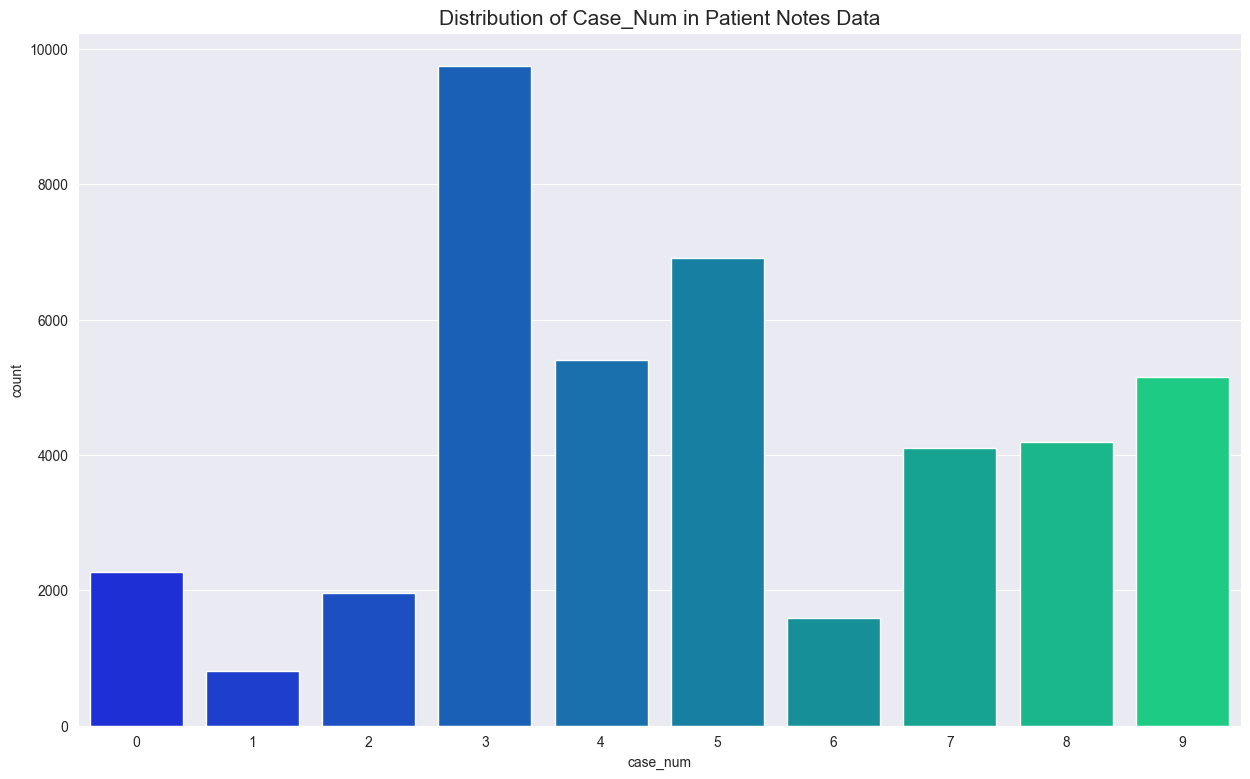

In [13]:
plt.figure(figsize=(15, 9))

sns.countplot(x='case_num', data=patient_note, palette = 'winter')
plt.title('Distribution of Case_Num in Patient Notes Data', fontsize=15)

plt.show()

### Then similarly we will inspect some patient history notes properties like number of words in it and the average word length distributions.

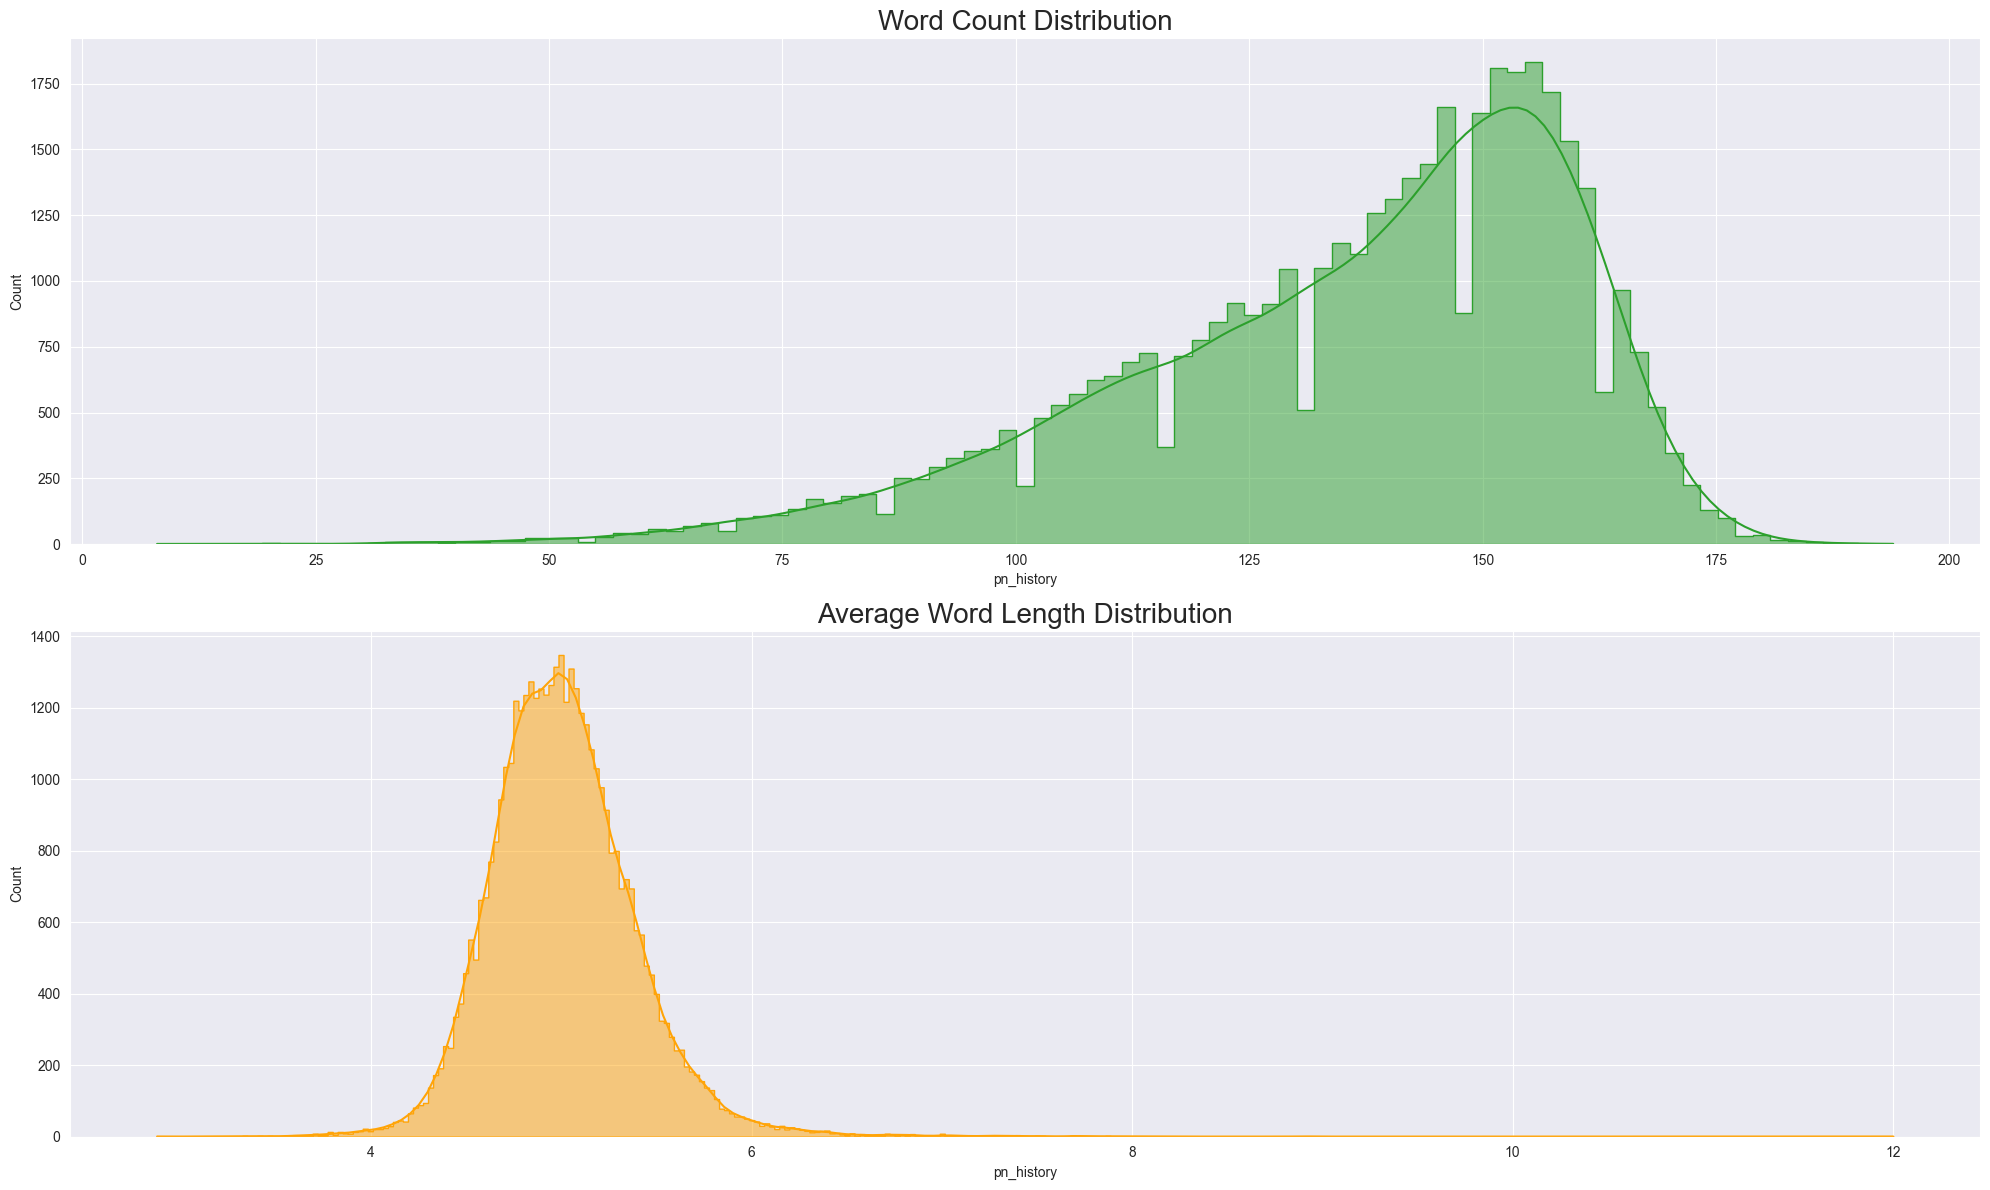

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

text_len = patient_note['pn_history'].str.split().map(lambda x : len(x))
sns.histplot(text_len, element="step", kde=True, color='#2ca02c', ax=ax[0])
ax[0].set_title('Word Count Distribution', size=20)

avg_word_len = patient_note['pn_history'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.histplot(avg_word_len, element="step", kde=True, color='#ffa408', ax=ax[1])
ax[1].set_title('Average Word Length Distribution', size=20)

plt.tight_layout()
plt.show()

## Annotations Visualization

In [15]:
# Reference - https://www.kaggle.com/vanguarde/nbme-eda
nlp = spacy.blank('en')
loc = list(train.loc[(train.pn_num==224) & (train.location!='[]'), 'location'].str.replace("['", "", regex=False).str.replace("']", "", regex=False))
text = patient_note[patient_note.pn_num==224].pn_history.values[0]
doc = nlp.make_doc(text)
ents = []
for l in loc:
    start, end = l.split(' ')
    ent = doc.char_span(int(start), int(end), label='annotation')
    ents.append(ent)
doc.ents = ents
color = {"Annotation": '#A32EFF'}
displacy.render(doc, style="ent", jupyter=True, options={'colors': color})

<br><br><br><br>

# Preprocessing

In [16]:
# Fixing incorrect annotation
train.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')

In [17]:
# Export the processed data
train.to_csv(PATH+"data/train_processed.csv")

<br>

# Bias Investiagtion

In [61]:
male   =  pd.read_csv(PATH + 'data/male.csv')
female =  pd.read_csv(PATH + 'data/female.csv')

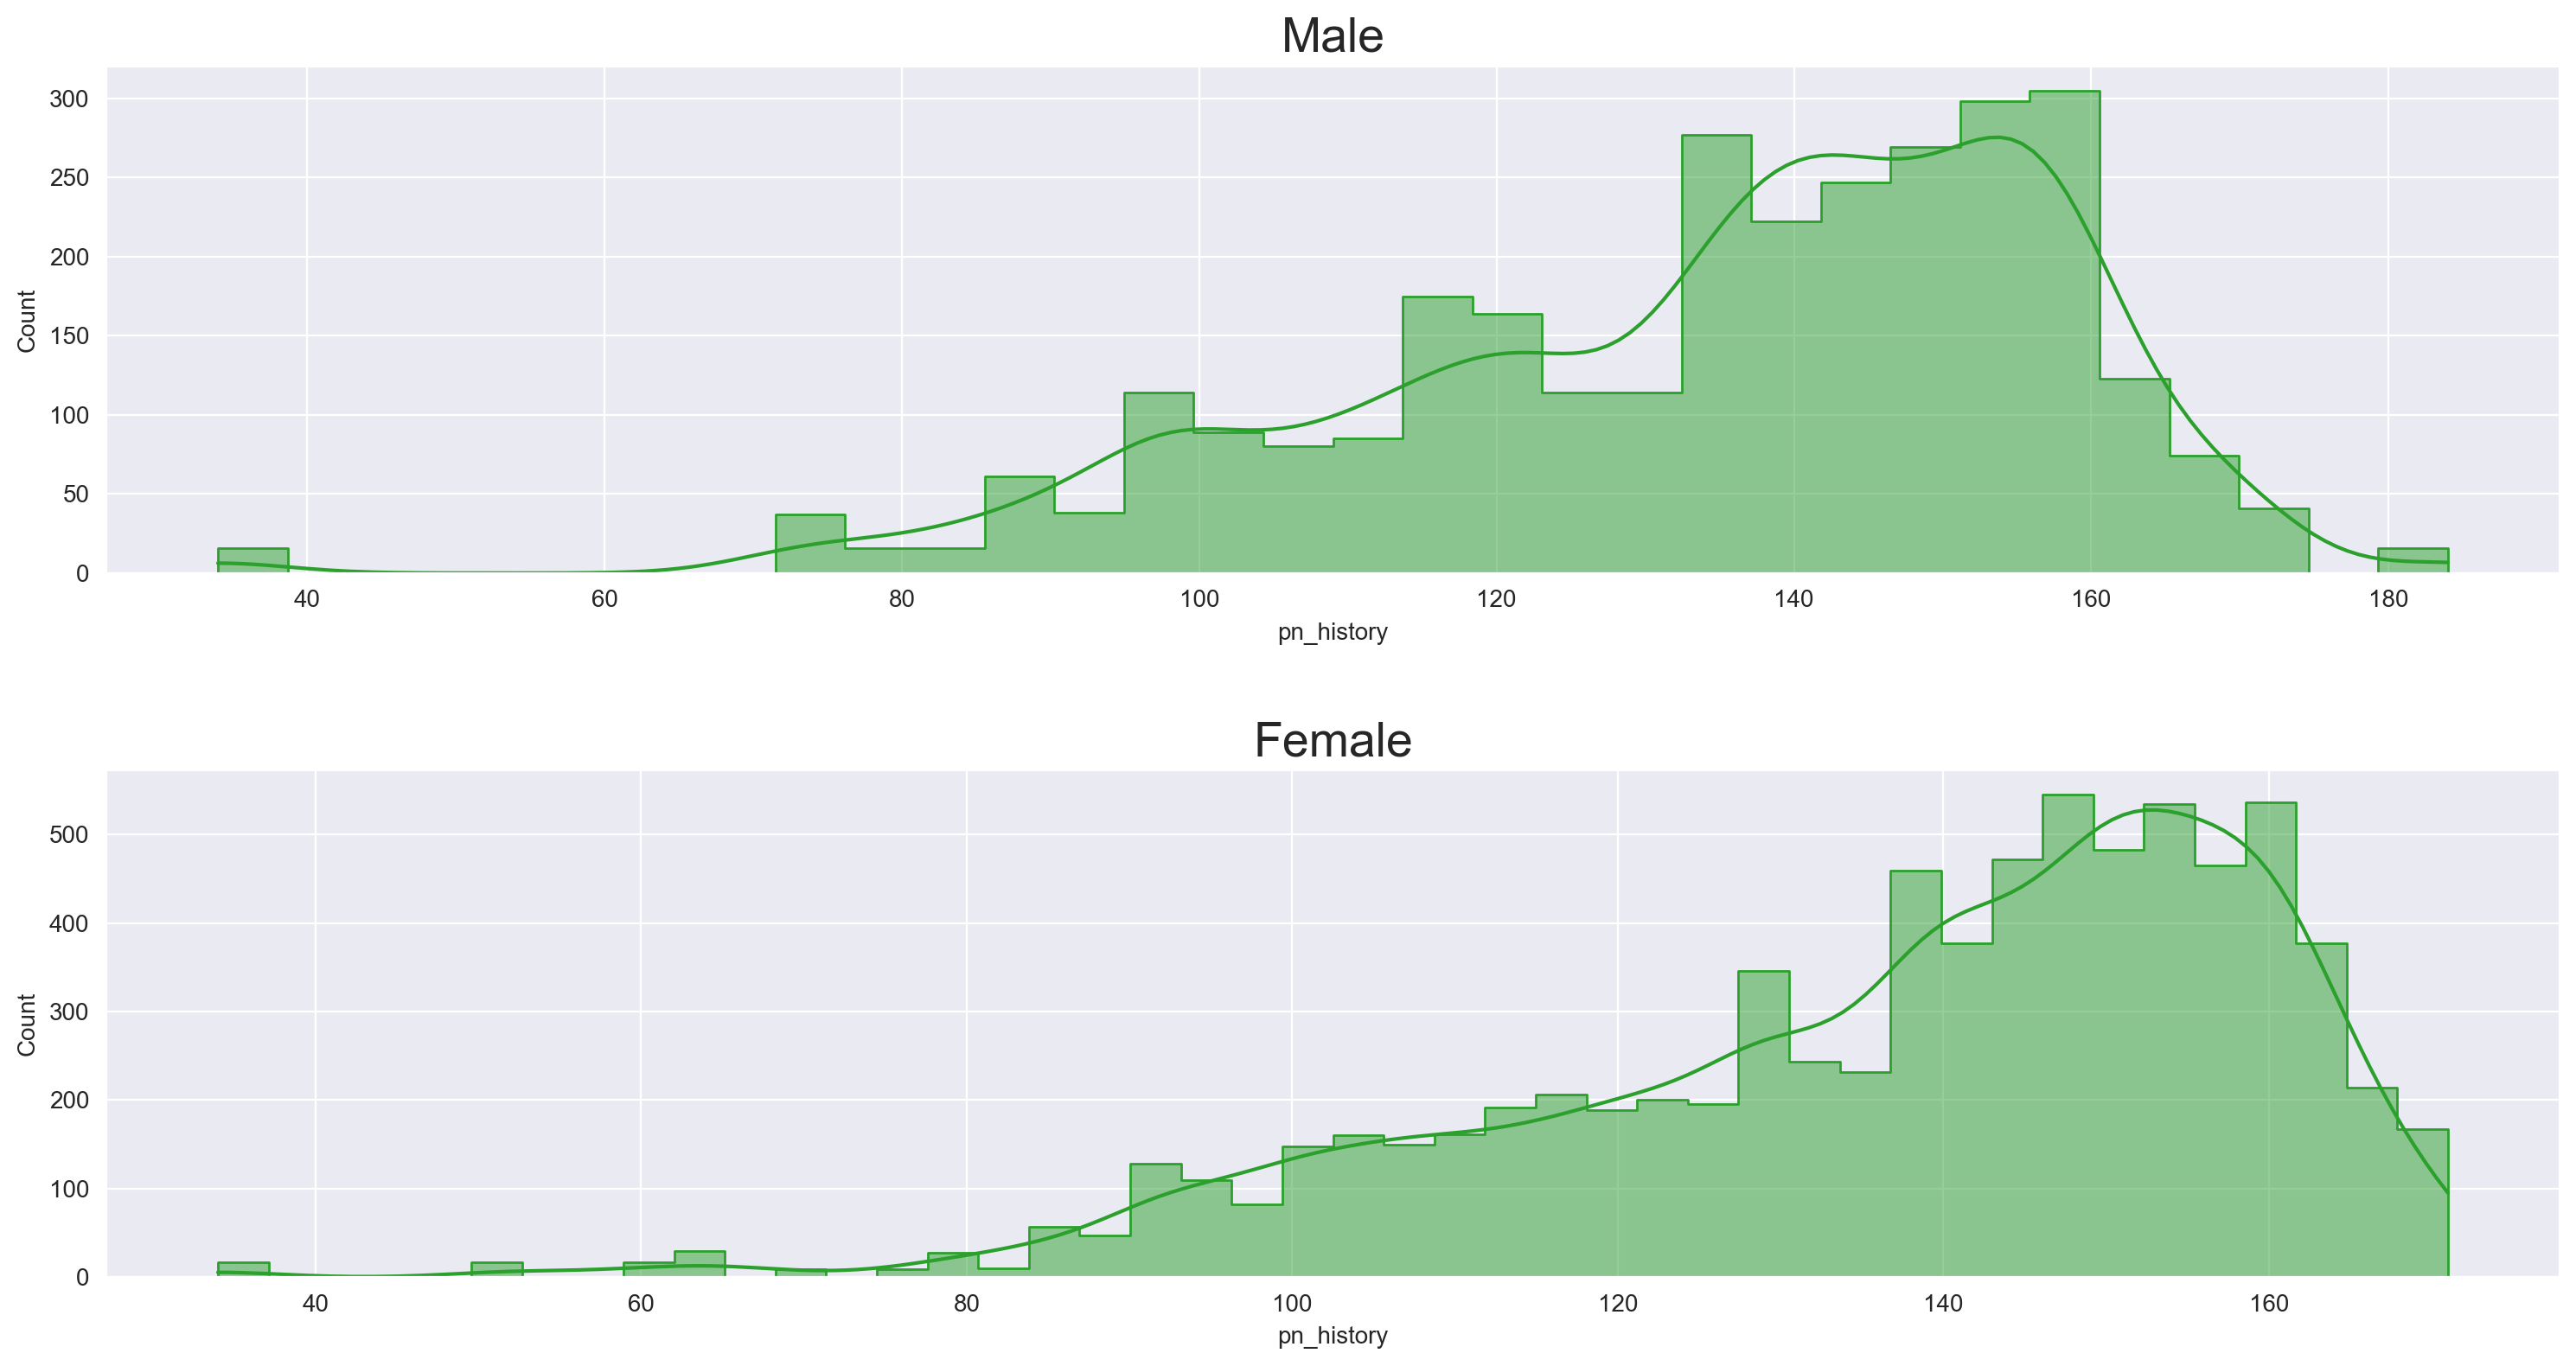

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), dpi=200)
# fig.suptitle('Patient Notes Word Count Distribution (Male vs Female)', size=30)

male['pn_history'] = male['pn_history'].str.split().map(lambda x : len(x))
sns.histplot(male['pn_history'], element="step", kde=True, color='#2ca02c', ax=ax[0])
ax[0].set_title('Male', size=20)

female['pn_history'] = female['pn_history'].str.split().map(lambda x : len(x))
sns.histplot(female['pn_history'], element="step", kde=True, color='#2ca02c', ax=ax[1])
ax[1].set_title('\nFemale', size=20)

plt.tight_layout()
plt.show()

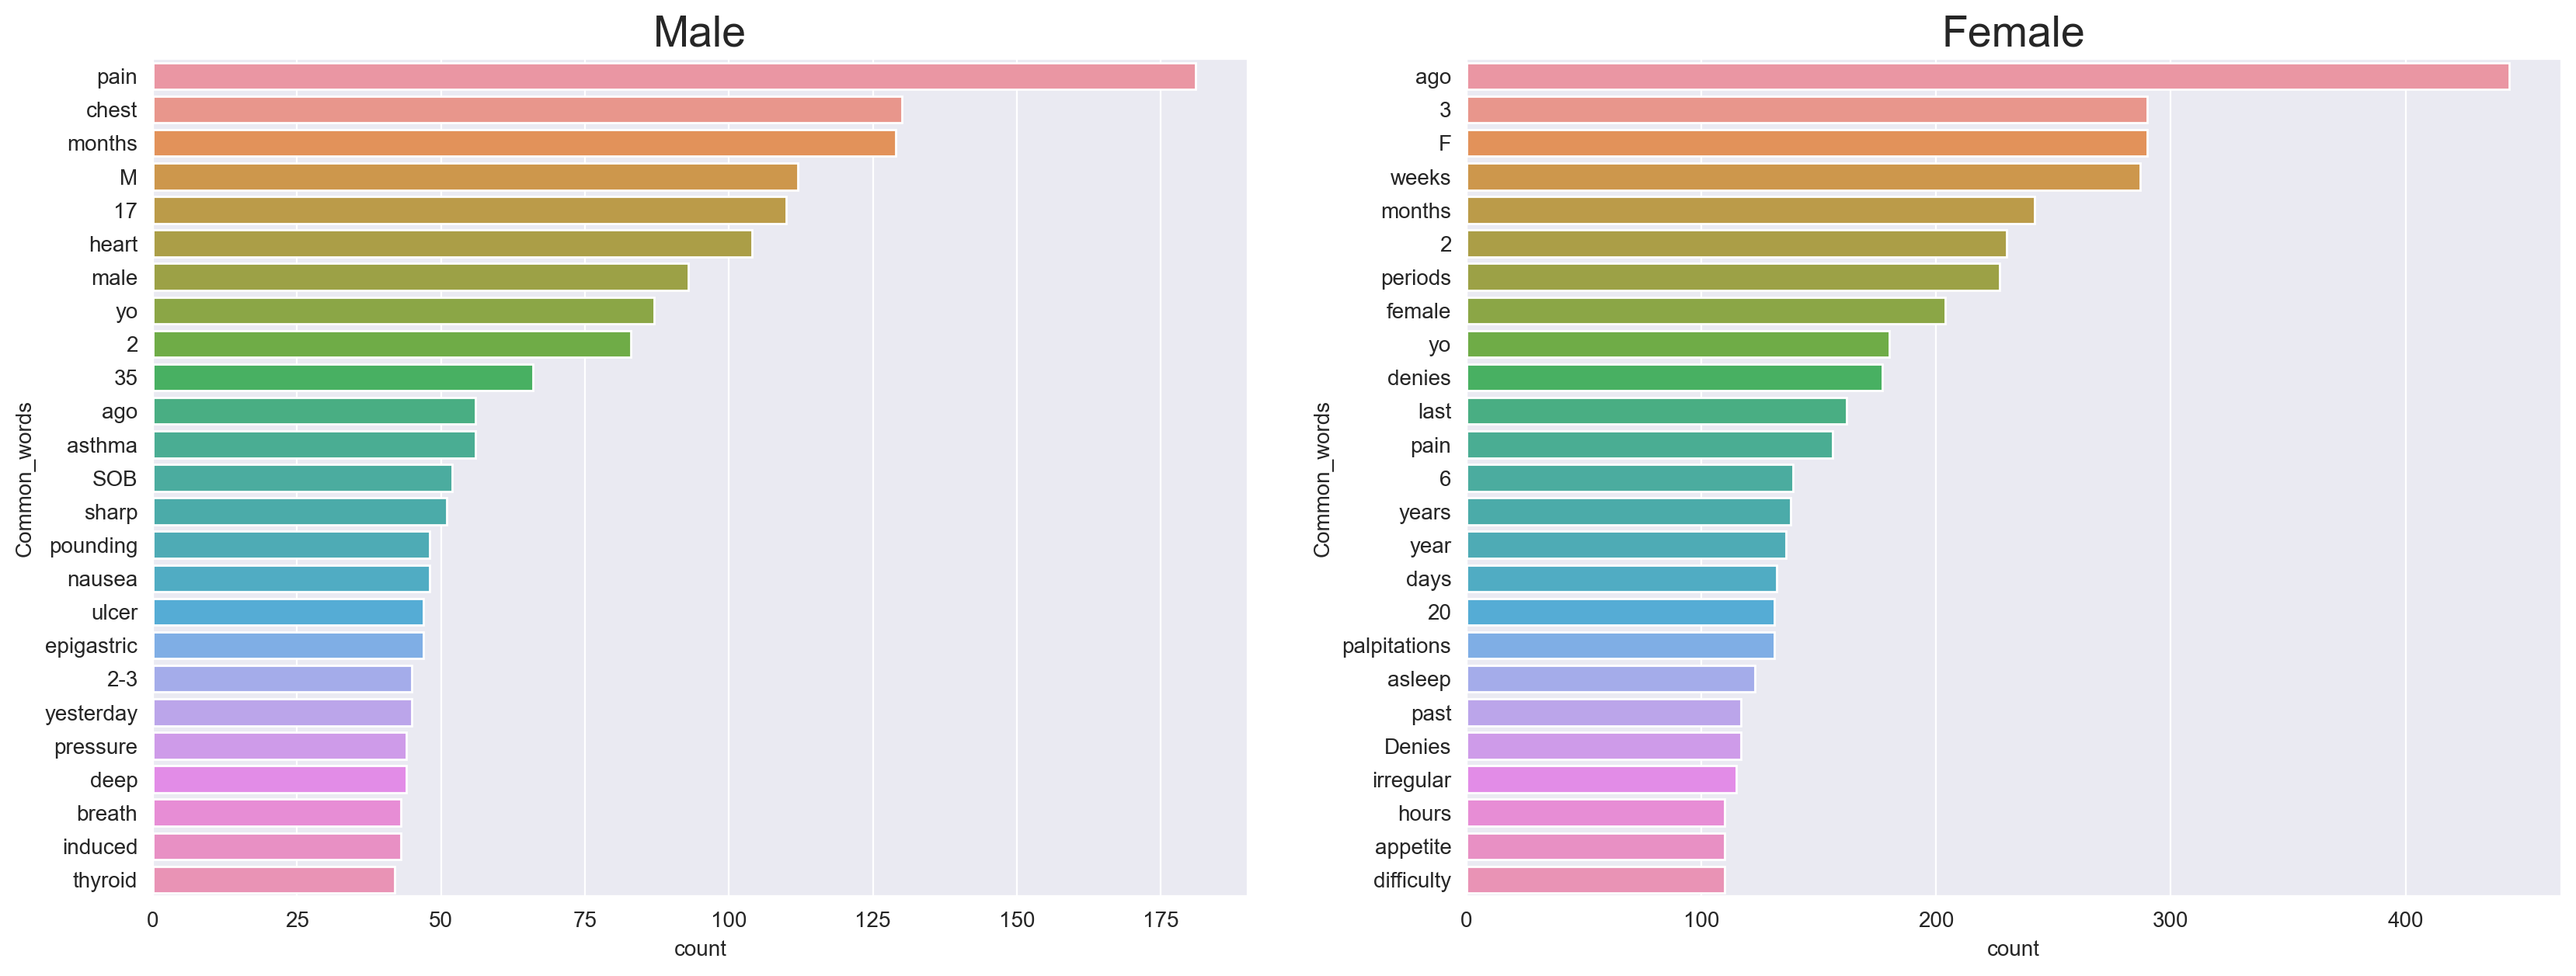

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7), dpi=200)
# fig.suptitle('Most Common Words in Annotations (Male vs Female)', size=30)

male['text'] = male['annotation'].apply(lambda x : join_fea(x))

top = Counter([word for words in male['text'] for word in words])
male_temp = pd.DataFrame(top.most_common(25))
male_temp.columns = ['Common_words','count']

sns.barplot(male_temp, x='count', y='Common_words', ax=ax[0])
ax[0].set_title('Male', size=20)

female['text'] = female['annotation'].apply(lambda x : join_fea(x))

top = Counter([word for words in female['text'] for word in words])
female_temp = pd.DataFrame(top.most_common(25))
female_temp.columns = ['Common_words','count']

sns.barplot(female_temp, x='count', y='Common_words', ax=ax[1])
ax[1].set_title('Female', size=20)

plt.show()

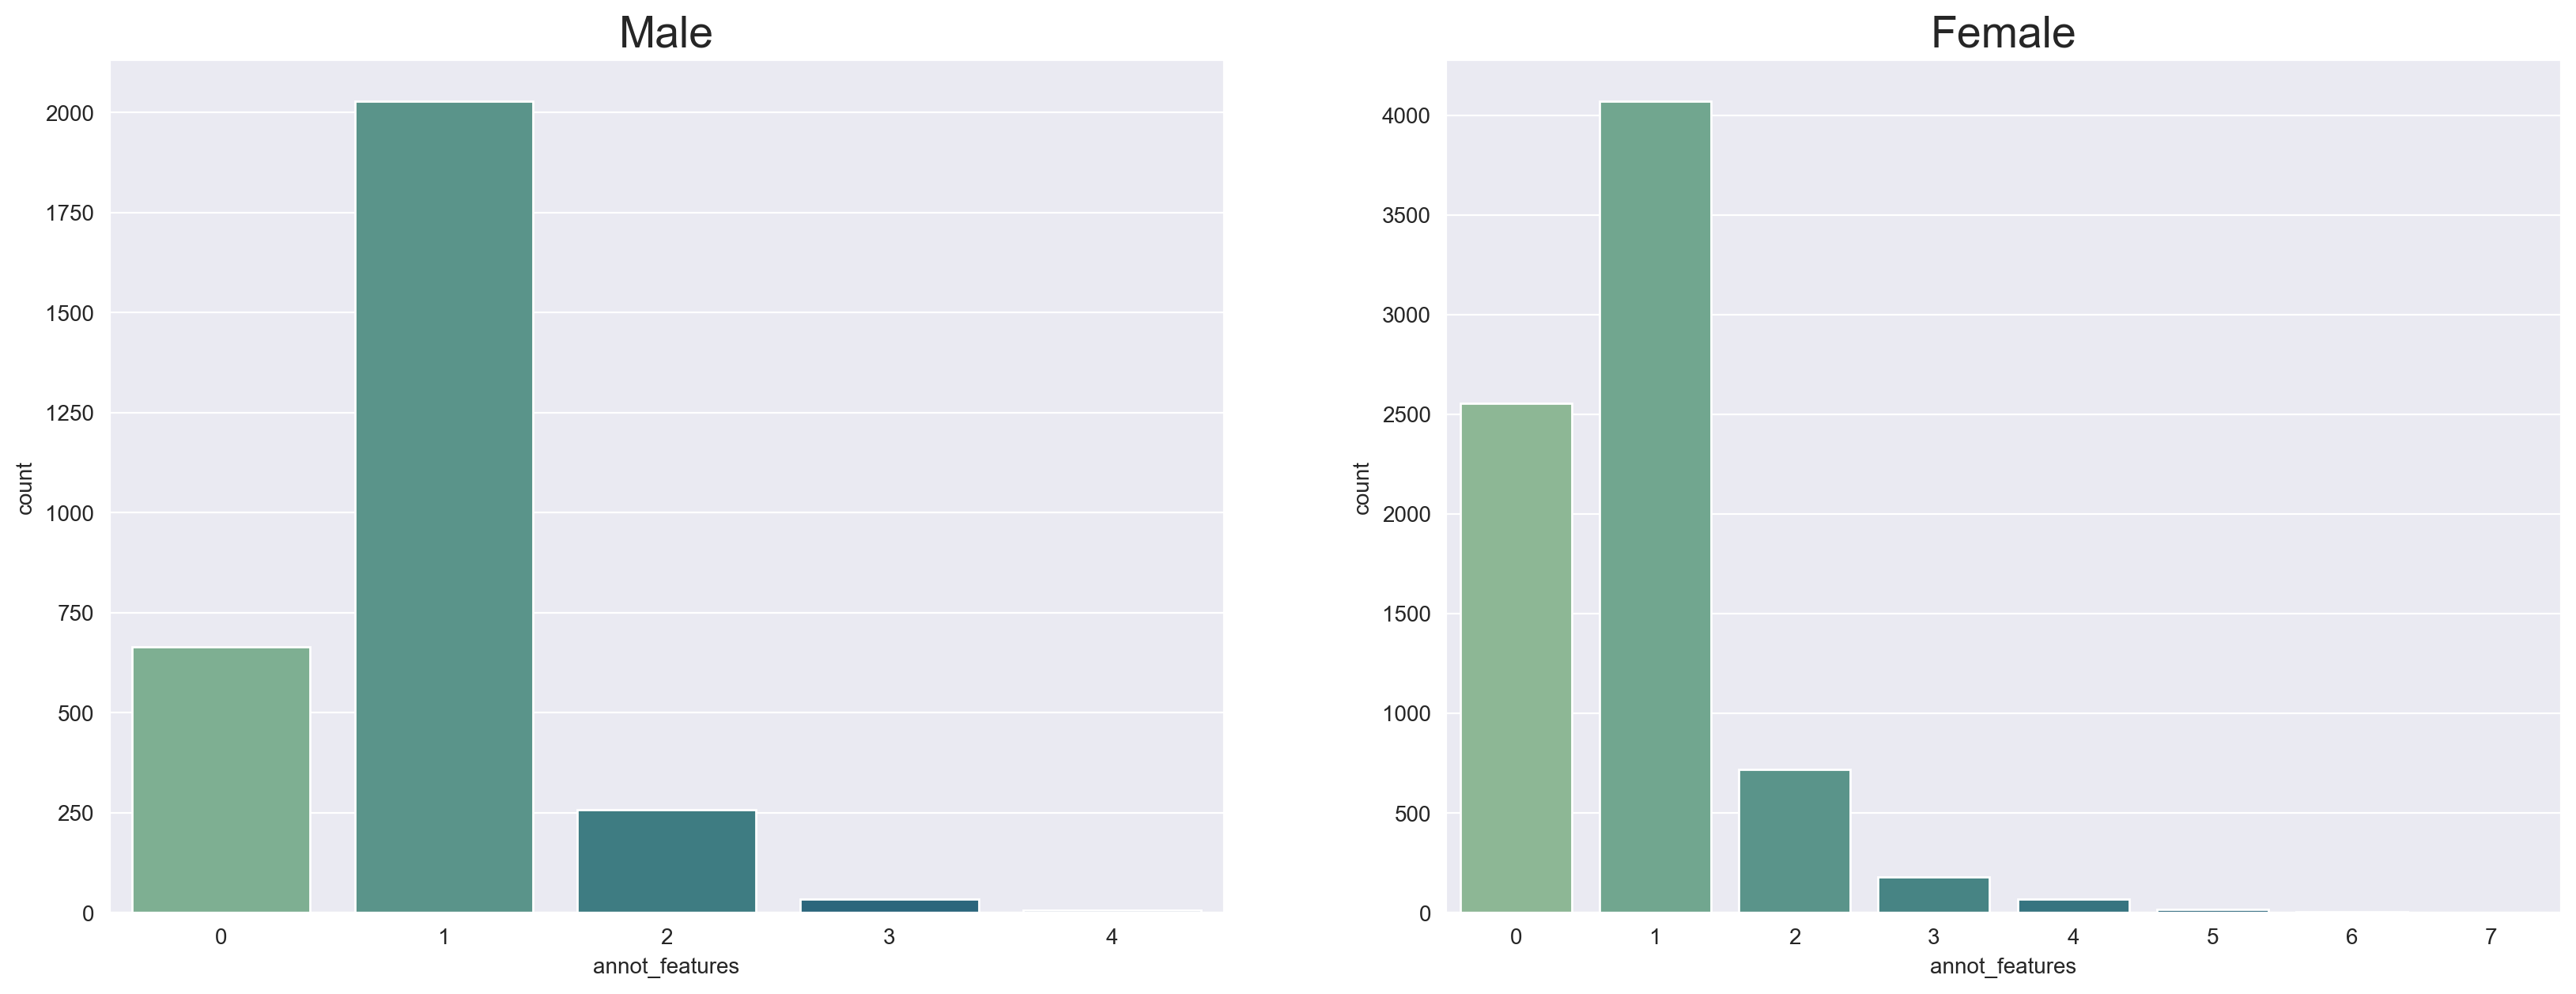

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7), dpi=200)
# fig.suptitle('Distribution of Number of Annotations (Male vs Female)', size=30)

male['annot_features'] = male['annotation'].apply(lambda x : len(ast.literal_eval(x))) 
sns.countplot(x=male['annot_features'], palette='crest', ax=ax[0])
ax[0].set_title('Male', size=20)

female['annot_features'] = female['annotation'].apply(lambda x : len(ast.literal_eval(x))) 
sns.countplot(x=female['annot_features'], palette='crest', ax=ax[1])
ax[1].set_title('Female', size=20)

plt.show()